In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from Tools.NNtools import *
import tempfile
import mlflow
import Experiments.Foong_L1W50.setup as exp
from Inference.Variational import MeanFieldVariationalDistribution
import argparse
import pandas as pd

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [44]:
max_iter=100000
learning_rate=0.01
min_lr=0.0005
n_ELBO_samples=1000 
patience=100
lr_decay=0.9
init_std=0.01
optimize=0
expansion=0


In [45]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [46]:
x_train, y_train = exp.get_training_data(device)
x_validation, y_validation = exp.get_validation_data(device)
x_test, y_test = exp.get_test_data(device)

In [69]:
logprior = exp.get_logprior_fn(device)

In [47]:
logposterior = exp.get_logposterior_fn(device)
x_train, y_train = exp.get_training_data(device)
x_validation, y_validation = exp.get_validation_data(device)
x_test, y_test = exp.get_test_data(device)
logtarget = lambda theta: logposterior(theta, x_train, y_train, 0.1)

In [52]:
init_std

0.01

In [98]:
model = MLP(1,50).to(device)

In [99]:
class MLP(nn.Module):
    def __init__(self, nblayers, layerwidth):
        super(MLP, self).__init__()
        L = [1] + [layerwidth]*nblayers + [1]
        self.layers = nn.ModuleList()
        for k in range(len(L)-1):
            self.layers.append(nn.Linear(L[k], L[k+1]))

    def forward(self, x):
        for j in range(len(self.layers)-1):
            x = torch.tanh(self.layers[j](x))
        x = self.layers[-1](x)
        return x

In [97]:
std = torch.tensor(init_std)
theta = torch.nn.Parameter(torch.empty([1, exp.param_count], device=device).normal_(std=std), requires_grad=True)

In [104]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay)

In [105]:
for t in range(100000):
    optimizer.zero_grad()

    LP = torch.stack([exp._log_norm(torch.tensor(0.0), m, torch.tensor(1.0)).sum() for m in model.parameters()]).sum()
    LL = exp._log_norm(model(x_train), y_train.unsqueeze(0).repeat(1, 1, 1), torch.tensor([0.1], device=device)).sum()
    L = -LL - LP
    L.backward()

    lr = optimizer.param_groups[0]['lr']
    scheduler.step(L.detach().clone().cpu().numpy())


    stats = 'Epoch [{}/{}], Training Loss: {}, Learning Rate: {}'.format(t, max_iter, L, lr)
    print(stats)

    if lr < min_lr:
        break
    optimizer.step()

Epoch [0/100000], Training Loss: -20.643386840820312, Learning Rate: 0.05
Epoch [1/100000], Training Loss: 480.46600341796875, Learning Rate: 0.05
Epoch [2/100000], Training Loss: 601.5391845703125, Learning Rate: 0.05
Epoch [3/100000], Training Loss: 182.64456176757812, Learning Rate: 0.05
Epoch [4/100000], Training Loss: 37.86041259765625, Learning Rate: 0.05
Epoch [5/100000], Training Loss: 236.24935913085938, Learning Rate: 0.05
Epoch [6/100000], Training Loss: 128.4328155517578, Learning Rate: 0.05
Epoch [7/100000], Training Loss: -2.4320220947265625, Learning Rate: 0.05
Epoch [8/100000], Training Loss: 57.212867736816406, Learning Rate: 0.05
Epoch [9/100000], Training Loss: 149.36746215820312, Learning Rate: 0.05
Epoch [10/100000], Training Loss: 97.75018310546875, Learning Rate: 0.05
Epoch [11/100000], Training Loss: -1.681396484375, Learning Rate: 0.05
Epoch [12/100000], Training Loss: -5.9177703857421875, Learning Rate: 0.05
Epoch [13/100000], Training Loss: 62.38002014160156,

Epoch [132/100000], Training Loss: -20.812240600585938, Learning Rate: 0.05
Epoch [133/100000], Training Loss: -20.813796997070312, Learning Rate: 0.05
Epoch [134/100000], Training Loss: -20.815277099609375, Learning Rate: 0.05
Epoch [135/100000], Training Loss: -20.816238403320312, Learning Rate: 0.05
Epoch [136/100000], Training Loss: -20.817398071289062, Learning Rate: 0.05
Epoch [137/100000], Training Loss: -20.818939208984375, Learning Rate: 0.05
Epoch [138/100000], Training Loss: -20.82012939453125, Learning Rate: 0.05
Epoch [139/100000], Training Loss: -20.8211669921875, Learning Rate: 0.05
Epoch [140/100000], Training Loss: -20.822494506835938, Learning Rate: 0.05
Epoch [141/100000], Training Loss: -20.823898315429688, Learning Rate: 0.05
Epoch [142/100000], Training Loss: -20.824981689453125, Learning Rate: 0.05
Epoch [143/100000], Training Loss: -20.826141357421875, Learning Rate: 0.05
Epoch [144/100000], Training Loss: -20.8275146484375, Learning Rate: 0.05
Epoch [145/100000

Epoch [267/100000], Training Loss: -20.948745727539062, Learning Rate: 0.05
Epoch [268/100000], Training Loss: -20.949493408203125, Learning Rate: 0.05
Epoch [269/100000], Training Loss: -20.950210571289062, Learning Rate: 0.05
Epoch [270/100000], Training Loss: -20.951004028320312, Learning Rate: 0.05
Epoch [271/100000], Training Loss: -20.951766967773438, Learning Rate: 0.05
Epoch [272/100000], Training Loss: -20.952484130859375, Learning Rate: 0.05
Epoch [273/100000], Training Loss: -20.953201293945312, Learning Rate: 0.05
Epoch [274/100000], Training Loss: -20.953933715820312, Learning Rate: 0.05
Epoch [275/100000], Training Loss: -20.9547119140625, Learning Rate: 0.05
Epoch [276/100000], Training Loss: -20.9554443359375, Learning Rate: 0.05
Epoch [277/100000], Training Loss: -20.956161499023438, Learning Rate: 0.05
Epoch [278/100000], Training Loss: -20.956863403320312, Learning Rate: 0.05
Epoch [279/100000], Training Loss: -20.95758056640625, Learning Rate: 0.05
Epoch [280/100000

Epoch [402/100000], Training Loss: -21.030044555664062, Learning Rate: 0.05
Epoch [403/100000], Training Loss: -21.030563354492188, Learning Rate: 0.05
Epoch [404/100000], Training Loss: -21.031021118164062, Learning Rate: 0.05
Epoch [405/100000], Training Loss: -21.031509399414062, Learning Rate: 0.05
Epoch [406/100000], Training Loss: -21.03204345703125, Learning Rate: 0.05
Epoch [407/100000], Training Loss: -21.032470703125, Learning Rate: 0.05
Epoch [408/100000], Training Loss: -21.03302001953125, Learning Rate: 0.05
Epoch [409/100000], Training Loss: -21.03350830078125, Learning Rate: 0.05
Epoch [410/100000], Training Loss: -21.034027099609375, Learning Rate: 0.05
Epoch [411/100000], Training Loss: -21.034515380859375, Learning Rate: 0.05
Epoch [412/100000], Training Loss: -21.035018920898438, Learning Rate: 0.05
Epoch [413/100000], Training Loss: -21.035507202148438, Learning Rate: 0.05
Epoch [414/100000], Training Loss: -21.035980224609375, Learning Rate: 0.05
Epoch [415/100000]

Epoch [536/100000], Training Loss: -21.0916748046875, Learning Rate: 0.05
Epoch [537/100000], Training Loss: -21.092071533203125, Learning Rate: 0.05
Epoch [538/100000], Training Loss: -21.092498779296875, Learning Rate: 0.05
Epoch [539/100000], Training Loss: -21.092880249023438, Learning Rate: 0.05
Epoch [540/100000], Training Loss: -21.093368530273438, Learning Rate: 0.05
Epoch [541/100000], Training Loss: -21.093795776367188, Learning Rate: 0.05
Epoch [542/100000], Training Loss: -21.09423828125, Learning Rate: 0.05
Epoch [543/100000], Training Loss: -21.094680786132812, Learning Rate: 0.05
Epoch [544/100000], Training Loss: -21.095108032226562, Learning Rate: 0.05
Epoch [545/100000], Training Loss: -21.095489501953125, Learning Rate: 0.05
Epoch [546/100000], Training Loss: -21.095947265625, Learning Rate: 0.05
Epoch [547/100000], Training Loss: -21.096389770507812, Learning Rate: 0.05
Epoch [548/100000], Training Loss: -21.0968017578125, Learning Rate: 0.05
Epoch [549/100000], Tra

Epoch [672/100000], Training Loss: -21.033493041992188, Learning Rate: 0.045000000000000005
Epoch [673/100000], Training Loss: -21.0340576171875, Learning Rate: 0.045000000000000005
Epoch [674/100000], Training Loss: -21.0340576171875, Learning Rate: 0.045000000000000005
Epoch [675/100000], Training Loss: -21.03472900390625, Learning Rate: 0.045000000000000005
Epoch [676/100000], Training Loss: -21.034744262695312, Learning Rate: 0.045000000000000005
Epoch [677/100000], Training Loss: -21.035186767578125, Learning Rate: 0.045000000000000005
Epoch [678/100000], Training Loss: -21.0355224609375, Learning Rate: 0.045000000000000005
Epoch [679/100000], Training Loss: -21.035720825195312, Learning Rate: 0.045000000000000005
Epoch [680/100000], Training Loss: -21.036163330078125, Learning Rate: 0.045000000000000005
Epoch [681/100000], Training Loss: -21.036331176757812, Learning Rate: 0.045000000000000005
Epoch [682/100000], Training Loss: -21.036727905273438, Learning Rate: 0.04500000000000

Epoch [808/100000], Training Loss: -21.071578979492188, Learning Rate: 0.04050000000000001
Epoch [809/100000], Training Loss: -21.071868896484375, Learning Rate: 0.04050000000000001
Epoch [810/100000], Training Loss: -21.072097778320312, Learning Rate: 0.04050000000000001
Epoch [811/100000], Training Loss: -21.072357177734375, Learning Rate: 0.04050000000000001
Epoch [812/100000], Training Loss: -21.0726318359375, Learning Rate: 0.04050000000000001
Epoch [813/100000], Training Loss: -21.0728759765625, Learning Rate: 0.04050000000000001
Epoch [814/100000], Training Loss: -21.073135375976562, Learning Rate: 0.04050000000000001
Epoch [815/100000], Training Loss: -21.073379516601562, Learning Rate: 0.04050000000000001
Epoch [816/100000], Training Loss: -21.073638916015625, Learning Rate: 0.04050000000000001
Epoch [817/100000], Training Loss: -21.073944091796875, Learning Rate: 0.04050000000000001
Epoch [818/100000], Training Loss: -21.074188232421875, Learning Rate: 0.04050000000000001
Epo

Epoch [937/100000], Training Loss: -21.104248046875, Learning Rate: 0.03645000000000001
Epoch [938/100000], Training Loss: -21.1044921875, Learning Rate: 0.03645000000000001
Epoch [939/100000], Training Loss: -21.104736328125, Learning Rate: 0.03645000000000001
Epoch [940/100000], Training Loss: -21.10498046875, Learning Rate: 0.03645000000000001
Epoch [941/100000], Training Loss: -21.105270385742188, Learning Rate: 0.03645000000000001
Epoch [942/100000], Training Loss: -21.105514526367188, Learning Rate: 0.03645000000000001
Epoch [943/100000], Training Loss: -21.105743408203125, Learning Rate: 0.03645000000000001
Epoch [944/100000], Training Loss: -21.10601806640625, Learning Rate: 0.03645000000000001
Epoch [945/100000], Training Loss: -21.106246948242188, Learning Rate: 0.03645000000000001
Epoch [946/100000], Training Loss: -21.106491088867188, Learning Rate: 0.03645000000000001
Epoch [947/100000], Training Loss: -21.106796264648438, Learning Rate: 0.03645000000000001
Epoch [948/1000

Epoch [1073/100000], Training Loss: -21.139678955078125, Learning Rate: 0.03645000000000001
Epoch [1074/100000], Training Loss: -21.139938354492188, Learning Rate: 0.03645000000000001
Epoch [1075/100000], Training Loss: -21.140182495117188, Learning Rate: 0.03645000000000001
Epoch [1076/100000], Training Loss: -21.140457153320312, Learning Rate: 0.03645000000000001
Epoch [1077/100000], Training Loss: -21.1407470703125, Learning Rate: 0.03645000000000001
Epoch [1078/100000], Training Loss: -21.141006469726562, Learning Rate: 0.03645000000000001
Epoch [1079/100000], Training Loss: -21.141281127929688, Learning Rate: 0.03645000000000001
Epoch [1080/100000], Training Loss: -21.141571044921875, Learning Rate: 0.03645000000000001
Epoch [1081/100000], Training Loss: -21.141799926757812, Learning Rate: 0.03645000000000001
Epoch [1082/100000], Training Loss: -21.142105102539062, Learning Rate: 0.03645000000000001
Epoch [1083/100000], Training Loss: -21.142333984375, Learning Rate: 0.03645000000

Epoch [1209/100000], Training Loss: -21.082931518554688, Learning Rate: 0.03645000000000001
Epoch [1210/100000], Training Loss: -21.085708618164062, Learning Rate: 0.03645000000000001
Epoch [1211/100000], Training Loss: -21.093521118164062, Learning Rate: 0.03645000000000001
Epoch [1212/100000], Training Loss: -21.083755493164062, Learning Rate: 0.03645000000000001
Epoch [1213/100000], Training Loss: -21.09246826171875, Learning Rate: 0.03645000000000001
Epoch [1214/100000], Training Loss: -21.091461181640625, Learning Rate: 0.03645000000000001
Epoch [1215/100000], Training Loss: -21.087799072265625, Learning Rate: 0.03645000000000001
Epoch [1216/100000], Training Loss: -21.095352172851562, Learning Rate: 0.03645000000000001
Epoch [1217/100000], Training Loss: -21.090545654296875, Learning Rate: 0.03645000000000001
Epoch [1218/100000], Training Loss: -21.092315673828125, Learning Rate: 0.03645000000000001
Epoch [1219/100000], Training Loss: -21.095687866210938, Learning Rate: 0.0364500

Epoch [1345/100000], Training Loss: -21.118927001953125, Learning Rate: 0.02952450000000001
Epoch [1346/100000], Training Loss: -21.119140625, Learning Rate: 0.02952450000000001
Epoch [1347/100000], Training Loss: -21.119308471679688, Learning Rate: 0.02952450000000001
Epoch [1348/100000], Training Loss: -21.119461059570312, Learning Rate: 0.02952450000000001
Epoch [1349/100000], Training Loss: -21.119583129882812, Learning Rate: 0.02952450000000001
Epoch [1350/100000], Training Loss: -21.119781494140625, Learning Rate: 0.02952450000000001
Epoch [1351/100000], Training Loss: -21.119949340820312, Learning Rate: 0.02952450000000001
Epoch [1352/100000], Training Loss: -21.120101928710938, Learning Rate: 0.02952450000000001
Epoch [1353/100000], Training Loss: -21.120223999023438, Learning Rate: 0.02952450000000001
Epoch [1354/100000], Training Loss: -21.120437622070312, Learning Rate: 0.02952450000000001
Epoch [1355/100000], Training Loss: -21.120635986328125, Learning Rate: 0.029524500000

Epoch [1481/100000], Training Loss: -21.141143798828125, Learning Rate: 0.02657205000000001
Epoch [1482/100000], Training Loss: -21.141357421875, Learning Rate: 0.02657205000000001
Epoch [1483/100000], Training Loss: -21.14154052734375, Learning Rate: 0.02657205000000001
Epoch [1484/100000], Training Loss: -21.141693115234375, Learning Rate: 0.02657205000000001
Epoch [1485/100000], Training Loss: -21.141830444335938, Learning Rate: 0.02657205000000001
Epoch [1486/100000], Training Loss: -21.141983032226562, Learning Rate: 0.02657205000000001
Epoch [1487/100000], Training Loss: -21.142166137695312, Learning Rate: 0.02657205000000001
Epoch [1488/100000], Training Loss: -21.142303466796875, Learning Rate: 0.02657205000000001
Epoch [1489/100000], Training Loss: -21.14251708984375, Learning Rate: 0.02657205000000001
Epoch [1490/100000], Training Loss: -21.142654418945312, Learning Rate: 0.02657205000000001
Epoch [1491/100000], Training Loss: -21.142807006835938, Learning Rate: 0.02657205000

Epoch [1616/100000], Training Loss: -21.162811279296875, Learning Rate: 0.02391484500000001
Epoch [1617/100000], Training Loss: -21.1629638671875, Learning Rate: 0.02391484500000001
Epoch [1618/100000], Training Loss: -21.1630859375, Learning Rate: 0.02391484500000001
Epoch [1619/100000], Training Loss: -21.163284301757812, Learning Rate: 0.02391484500000001
Epoch [1620/100000], Training Loss: -21.163436889648438, Learning Rate: 0.02391484500000001
Epoch [1621/100000], Training Loss: -21.163604736328125, Learning Rate: 0.02391484500000001
Epoch [1622/100000], Training Loss: -21.163742065429688, Learning Rate: 0.02391484500000001
Epoch [1623/100000], Training Loss: -21.163909912109375, Learning Rate: 0.02391484500000001
Epoch [1624/100000], Training Loss: -21.1640625, Learning Rate: 0.02391484500000001
Epoch [1625/100000], Training Loss: -21.164230346679688, Learning Rate: 0.02391484500000001
Epoch [1626/100000], Training Loss: -21.164398193359375, Learning Rate: 0.02391484500000001
Epo

Epoch [1744/100000], Training Loss: -21.1842041015625, Learning Rate: 0.02391484500000001
Epoch [1745/100000], Training Loss: -21.184356689453125, Learning Rate: 0.02391484500000001
Epoch [1746/100000], Training Loss: -21.184555053710938, Learning Rate: 0.02391484500000001
Epoch [1747/100000], Training Loss: -21.184722900390625, Learning Rate: 0.02391484500000001
Epoch [1748/100000], Training Loss: -21.18487548828125, Learning Rate: 0.02391484500000001
Epoch [1749/100000], Training Loss: -21.185028076171875, Learning Rate: 0.02391484500000001
Epoch [1750/100000], Training Loss: -21.18524169921875, Learning Rate: 0.02391484500000001
Epoch [1751/100000], Training Loss: -21.185379028320312, Learning Rate: 0.02391484500000001
Epoch [1752/100000], Training Loss: -21.185562133789062, Learning Rate: 0.02391484500000001
Epoch [1753/100000], Training Loss: -21.185745239257812, Learning Rate: 0.02391484500000001
Epoch [1754/100000], Training Loss: -21.1859130859375, Learning Rate: 0.023914845000

Epoch [1878/100000], Training Loss: -21.044235229492188, Learning Rate: 0.02391484500000001
Epoch [1879/100000], Training Loss: -20.279541015625, Learning Rate: 0.02391484500000001
Epoch [1880/100000], Training Loss: -21.05902099609375, Learning Rate: 0.02391484500000001
Epoch [1881/100000], Training Loss: -20.705078125, Learning Rate: 0.02391484500000001
Epoch [1882/100000], Training Loss: -20.703964233398438, Learning Rate: 0.02391484500000001
Epoch [1883/100000], Training Loss: -21.101760864257812, Learning Rate: 0.02391484500000001
Epoch [1884/100000], Training Loss: -20.632095336914062, Learning Rate: 0.02391484500000001
Epoch [1885/100000], Training Loss: -21.080810546875, Learning Rate: 0.02391484500000001
Epoch [1886/100000], Training Loss: -20.899307250976562, Learning Rate: 0.02391484500000001
Epoch [1887/100000], Training Loss: -20.881423950195312, Learning Rate: 0.02391484500000001
Epoch [1888/100000], Training Loss: -21.1251220703125, Learning Rate: 0.02391484500000001
Epo

Epoch [2012/100000], Training Loss: -21.1611328125, Learning Rate: 0.021523360500000012
Epoch [2013/100000], Training Loss: -21.161209106445312, Learning Rate: 0.021523360500000012
Epoch [2014/100000], Training Loss: -21.161331176757812, Learning Rate: 0.021523360500000012
Epoch [2015/100000], Training Loss: -21.16143798828125, Learning Rate: 0.021523360500000012
Epoch [2016/100000], Training Loss: -21.161575317382812, Learning Rate: 0.021523360500000012
Epoch [2017/100000], Training Loss: -21.161697387695312, Learning Rate: 0.021523360500000012
Epoch [2018/100000], Training Loss: -21.16180419921875, Learning Rate: 0.021523360500000012
Epoch [2019/100000], Training Loss: -21.161865234375, Learning Rate: 0.021523360500000012
Epoch [2020/100000], Training Loss: -21.161972045898438, Learning Rate: 0.021523360500000012
Epoch [2021/100000], Training Loss: -21.162109375, Learning Rate: 0.021523360500000012
Epoch [2022/100000], Training Loss: -21.162277221679688, Learning Rate: 0.021523360500

Epoch [2147/100000], Training Loss: -21.175247192382812, Learning Rate: 0.01743392200500001
Epoch [2148/100000], Training Loss: -21.17529296875, Learning Rate: 0.01743392200500001
Epoch [2149/100000], Training Loss: -21.17535400390625, Learning Rate: 0.01743392200500001
Epoch [2150/100000], Training Loss: -21.175460815429688, Learning Rate: 0.01743392200500001
Epoch [2151/100000], Training Loss: -21.17559814453125, Learning Rate: 0.01743392200500001
Epoch [2152/100000], Training Loss: -21.175689697265625, Learning Rate: 0.01743392200500001
Epoch [2153/100000], Training Loss: -21.17578125, Learning Rate: 0.01743392200500001
Epoch [2154/100000], Training Loss: -21.175857543945312, Learning Rate: 0.01743392200500001
Epoch [2155/100000], Training Loss: -21.175979614257812, Learning Rate: 0.01743392200500001
Epoch [2156/100000], Training Loss: -21.176055908203125, Learning Rate: 0.01743392200500001
Epoch [2157/100000], Training Loss: -21.176177978515625, Learning Rate: 0.01743392200500001
E

Epoch [2281/100000], Training Loss: -21.188186645507812, Learning Rate: 0.015690529804500006
Epoch [2282/100000], Training Loss: -21.188262939453125, Learning Rate: 0.015690529804500006
Epoch [2283/100000], Training Loss: -21.18829345703125, Learning Rate: 0.015690529804500006
Epoch [2284/100000], Training Loss: -21.188446044921875, Learning Rate: 0.015690529804500006
Epoch [2285/100000], Training Loss: -21.18853759765625, Learning Rate: 0.015690529804500006
Epoch [2286/100000], Training Loss: -21.188644409179688, Learning Rate: 0.015690529804500006
Epoch [2287/100000], Training Loss: -21.188690185546875, Learning Rate: 0.015690529804500006
Epoch [2288/100000], Training Loss: -21.188812255859375, Learning Rate: 0.015690529804500006
Epoch [2289/100000], Training Loss: -21.188888549804688, Learning Rate: 0.015690529804500006
Epoch [2290/100000], Training Loss: -21.18896484375, Learning Rate: 0.015690529804500006
Epoch [2291/100000], Training Loss: -21.189117431640625, Learning Rate: 0.01

Epoch [2414/100000], Training Loss: -21.200607299804688, Learning Rate: 0.014121476824050006
Epoch [2415/100000], Training Loss: -21.200729370117188, Learning Rate: 0.014121476824050006
Epoch [2416/100000], Training Loss: -21.200790405273438, Learning Rate: 0.014121476824050006
Epoch [2417/100000], Training Loss: -21.200897216796875, Learning Rate: 0.014121476824050006
Epoch [2418/100000], Training Loss: -21.201004028320312, Learning Rate: 0.014121476824050006
Epoch [2419/100000], Training Loss: -21.201095581054688, Learning Rate: 0.014121476824050006
Epoch [2420/100000], Training Loss: -21.201171875, Learning Rate: 0.014121476824050006
Epoch [2421/100000], Training Loss: -21.201278686523438, Learning Rate: 0.014121476824050006
Epoch [2422/100000], Training Loss: -21.20135498046875, Learning Rate: 0.014121476824050006
Epoch [2423/100000], Training Loss: -21.201507568359375, Learning Rate: 0.014121476824050006
Epoch [2424/100000], Training Loss: -21.20159912109375, Learning Rate: 0.0141

Epoch [2543/100000], Training Loss: -21.21319580078125, Learning Rate: 0.014121476824050006
Epoch [2544/100000], Training Loss: -21.2132568359375, Learning Rate: 0.014121476824050006
Epoch [2545/100000], Training Loss: -21.21337890625, Learning Rate: 0.014121476824050006
Epoch [2546/100000], Training Loss: -21.21343994140625, Learning Rate: 0.014121476824050006
Epoch [2547/100000], Training Loss: -21.21356201171875, Learning Rate: 0.014121476824050006
Epoch [2548/100000], Training Loss: -21.213653564453125, Learning Rate: 0.014121476824050006
Epoch [2549/100000], Training Loss: -21.213760375976562, Learning Rate: 0.014121476824050006
Epoch [2550/100000], Training Loss: -21.213821411132812, Learning Rate: 0.014121476824050006
Epoch [2551/100000], Training Loss: -21.21392822265625, Learning Rate: 0.014121476824050006
Epoch [2552/100000], Training Loss: -21.214065551757812, Learning Rate: 0.014121476824050006
Epoch [2553/100000], Training Loss: -21.214157104492188, Learning Rate: 0.014121

Epoch [2674/100000], Training Loss: -21.2266845703125, Learning Rate: 0.014121476824050006
Epoch [2675/100000], Training Loss: -21.226806640625, Learning Rate: 0.014121476824050006
Epoch [2676/100000], Training Loss: -21.226898193359375, Learning Rate: 0.014121476824050006
Epoch [2677/100000], Training Loss: -21.227035522460938, Learning Rate: 0.014121476824050006
Epoch [2678/100000], Training Loss: -21.227142333984375, Learning Rate: 0.014121476824050006
Epoch [2679/100000], Training Loss: -21.227218627929688, Learning Rate: 0.014121476824050006
Epoch [2680/100000], Training Loss: -21.227325439453125, Learning Rate: 0.014121476824050006
Epoch [2681/100000], Training Loss: -21.227462768554688, Learning Rate: 0.014121476824050006
Epoch [2682/100000], Training Loss: -21.227554321289062, Learning Rate: 0.014121476824050006
Epoch [2683/100000], Training Loss: -21.227645874023438, Learning Rate: 0.014121476824050006
Epoch [2684/100000], Training Loss: -21.227752685546875, Learning Rate: 0.0

Epoch [2808/100000], Training Loss: -20.639404296875, Learning Rate: 0.014121476824050006
Epoch [2809/100000], Training Loss: -20.136978149414062, Learning Rate: 0.014121476824050006
Epoch [2810/100000], Training Loss: -19.241226196289062, Learning Rate: 0.014121476824050006
Epoch [2811/100000], Training Loss: -18.31689453125, Learning Rate: 0.014121476824050006
Epoch [2812/100000], Training Loss: -17.45233154296875, Learning Rate: 0.014121476824050006
Epoch [2813/100000], Training Loss: -18.165863037109375, Learning Rate: 0.014121476824050006
Epoch [2814/100000], Training Loss: -19.730300903320312, Learning Rate: 0.014121476824050006
Epoch [2815/100000], Training Loss: -21.111740112304688, Learning Rate: 0.014121476824050006
Epoch [2816/100000], Training Loss: -20.920852661132812, Learning Rate: 0.014121476824050006
Epoch [2817/100000], Training Loss: -19.861785888671875, Learning Rate: 0.014121476824050006
Epoch [2818/100000], Training Loss: -19.72882080078125, Learning Rate: 0.01412

Epoch [2944/100000], Training Loss: -21.240097045898438, Learning Rate: 0.014121476824050006
Epoch [2945/100000], Training Loss: -21.240188598632812, Learning Rate: 0.014121476824050006
Epoch [2946/100000], Training Loss: -21.240264892578125, Learning Rate: 0.014121476824050006
Epoch [2947/100000], Training Loss: -21.240341186523438, Learning Rate: 0.014121476824050006
Epoch [2948/100000], Training Loss: -21.240463256835938, Learning Rate: 0.014121476824050006
Epoch [2949/100000], Training Loss: -21.240524291992188, Learning Rate: 0.014121476824050006
Epoch [2950/100000], Training Loss: -21.24066162109375, Learning Rate: 0.014121476824050006
Epoch [2951/100000], Training Loss: -21.24078369140625, Learning Rate: 0.014121476824050006
Epoch [2952/100000], Training Loss: -21.2408447265625, Learning Rate: 0.014121476824050006
Epoch [2953/100000], Training Loss: -21.240982055664062, Learning Rate: 0.014121476824050006
Epoch [2954/100000], Training Loss: -21.241058349609375, Learning Rate: 0.

Epoch [3077/100000], Training Loss: -21.232803344726562, Learning Rate: 0.014121476824050006
Epoch [3078/100000], Training Loss: -20.7928466796875, Learning Rate: 0.014121476824050006
Epoch [3079/100000], Training Loss: -20.52239990234375, Learning Rate: 0.014121476824050006
Epoch [3080/100000], Training Loss: -21.054458618164062, Learning Rate: 0.014121476824050006
Epoch [3081/100000], Training Loss: -21.17041015625, Learning Rate: 0.014121476824050006
Epoch [3082/100000], Training Loss: -20.768264770507812, Learning Rate: 0.014121476824050006
Epoch [3083/100000], Training Loss: -20.897781372070312, Learning Rate: 0.014121476824050006
Epoch [3084/100000], Training Loss: -21.231796264648438, Learning Rate: 0.014121476824050006
Epoch [3085/100000], Training Loss: -21.028656005859375, Learning Rate: 0.014121476824050006
Epoch [3086/100000], Training Loss: -20.896148681640625, Learning Rate: 0.014121476824050006
Epoch [3087/100000], Training Loss: -21.168182373046875, Learning Rate: 0.014

Epoch [3211/100000], Training Loss: -21.244720458984375, Learning Rate: 0.012709329141645007
Epoch [3212/100000], Training Loss: -21.2447509765625, Learning Rate: 0.012709329141645007
Epoch [3213/100000], Training Loss: -21.24481201171875, Learning Rate: 0.012709329141645007
Epoch [3214/100000], Training Loss: -21.244964599609375, Learning Rate: 0.012709329141645007
Epoch [3215/100000], Training Loss: -21.245025634765625, Learning Rate: 0.012709329141645007
Epoch [3216/100000], Training Loss: -21.245132446289062, Learning Rate: 0.012709329141645007
Epoch [3217/100000], Training Loss: -21.245208740234375, Learning Rate: 0.012709329141645007
Epoch [3218/100000], Training Loss: -21.24530029296875, Learning Rate: 0.012709329141645007
Epoch [3219/100000], Training Loss: -21.245361328125, Learning Rate: 0.012709329141645007
Epoch [3220/100000], Training Loss: -21.245452880859375, Learning Rate: 0.012709329141645007
Epoch [3221/100000], Training Loss: -21.245498657226562, Learning Rate: 0.012

Epoch [3342/100000], Training Loss: -21.255142211914062, Learning Rate: 0.012709329141645007
Epoch [3343/100000], Training Loss: -21.25518798828125, Learning Rate: 0.012709329141645007
Epoch [3344/100000], Training Loss: -21.255294799804688, Learning Rate: 0.012709329141645007
Epoch [3345/100000], Training Loss: -21.255355834960938, Learning Rate: 0.012709329141645007
Epoch [3346/100000], Training Loss: -21.255447387695312, Learning Rate: 0.012709329141645007
Epoch [3347/100000], Training Loss: -21.2554931640625, Learning Rate: 0.012709329141645007
Epoch [3348/100000], Training Loss: -21.255569458007812, Learning Rate: 0.012709329141645007
Epoch [3349/100000], Training Loss: -21.255645751953125, Learning Rate: 0.012709329141645007
Epoch [3350/100000], Training Loss: -21.255722045898438, Learning Rate: 0.012709329141645007
Epoch [3351/100000], Training Loss: -21.25579833984375, Learning Rate: 0.012709329141645007
Epoch [3352/100000], Training Loss: -21.255889892578125, Learning Rate: 0.

Epoch [3476/100000], Training Loss: -21.258163452148438, Learning Rate: 0.012709329141645007
Epoch [3477/100000], Training Loss: -21.2469482421875, Learning Rate: 0.012709329141645007
Epoch [3478/100000], Training Loss: -21.243438720703125, Learning Rate: 0.012709329141645007
Epoch [3479/100000], Training Loss: -21.25347900390625, Learning Rate: 0.012709329141645007
Epoch [3480/100000], Training Loss: -21.25811767578125, Learning Rate: 0.012709329141645007
Epoch [3481/100000], Training Loss: -21.251602172851562, Learning Rate: 0.012709329141645007
Epoch [3482/100000], Training Loss: -21.249053955078125, Learning Rate: 0.012709329141645007
Epoch [3483/100000], Training Loss: -21.255722045898438, Learning Rate: 0.012709329141645007
Epoch [3484/100000], Training Loss: -21.259765625, Learning Rate: 0.012709329141645007
Epoch [3485/100000], Training Loss: -21.255935668945312, Learning Rate: 0.012709329141645007
Epoch [3486/100000], Training Loss: -21.253173828125, Learning Rate: 0.012709329

Epoch [3611/100000], Training Loss: -21.261383056640625, Learning Rate: 0.012709329141645007
Epoch [3612/100000], Training Loss: -21.262237548828125, Learning Rate: 0.012709329141645007
Epoch [3613/100000], Training Loss: -21.262619018554688, Learning Rate: 0.012709329141645007
Epoch [3614/100000], Training Loss: -21.262481689453125, Learning Rate: 0.012709329141645007
Epoch [3615/100000], Training Loss: -21.262069702148438, Learning Rate: 0.012709329141645007
Epoch [3616/100000], Training Loss: -21.261993408203125, Learning Rate: 0.012709329141645007
Epoch [3617/100000], Training Loss: -21.262313842773438, Learning Rate: 0.012709329141645007
Epoch [3618/100000], Training Loss: -21.262802124023438, Learning Rate: 0.012709329141645007
Epoch [3619/100000], Training Loss: -21.263092041015625, Learning Rate: 0.012709329141645007
Epoch [3620/100000], Training Loss: -21.263107299804688, Learning Rate: 0.012709329141645007
Epoch [3621/100000], Training Loss: -21.262939453125, Learning Rate: 0

Epoch [3743/100000], Training Loss: -20.672515869140625, Learning Rate: 0.012709329141645007
Epoch [3744/100000], Training Loss: -21.258316040039062, Learning Rate: 0.012709329141645007
Epoch [3745/100000], Training Loss: -20.785186767578125, Learning Rate: 0.012709329141645007
Epoch [3746/100000], Training Loss: -20.379776000976562, Learning Rate: 0.012709329141645007
Epoch [3747/100000], Training Loss: -20.86102294921875, Learning Rate: 0.012709329141645007
Epoch [3748/100000], Training Loss: -21.25201416015625, Learning Rate: 0.012709329141645007
Epoch [3749/100000], Training Loss: -20.934600830078125, Learning Rate: 0.012709329141645007
Epoch [3750/100000], Training Loss: -20.712936401367188, Learning Rate: 0.012709329141645007
Epoch [3751/100000], Training Loss: -21.040206909179688, Learning Rate: 0.012709329141645007
Epoch [3752/100000], Training Loss: -21.249679565429688, Learning Rate: 0.012709329141645007
Epoch [3753/100000], Training Loss: -21.007308959960938, Learning Rate: 

Epoch [3867/100000], Training Loss: -21.26776123046875, Learning Rate: 0.011438396227480507
Epoch [3868/100000], Training Loss: -21.267837524414062, Learning Rate: 0.011438396227480507
Epoch [3869/100000], Training Loss: -21.26788330078125, Learning Rate: 0.011438396227480507
Epoch [3870/100000], Training Loss: -21.2679443359375, Learning Rate: 0.011438396227480507
Epoch [3871/100000], Training Loss: -21.268035888671875, Learning Rate: 0.011438396227480507
Epoch [3872/100000], Training Loss: -21.26812744140625, Learning Rate: 0.011438396227480507
Epoch [3873/100000], Training Loss: -21.268173217773438, Learning Rate: 0.011438396227480507
Epoch [3874/100000], Training Loss: -21.268295288085938, Learning Rate: 0.011438396227480507
Epoch [3875/100000], Training Loss: -21.26837158203125, Learning Rate: 0.011438396227480507
Epoch [3876/100000], Training Loss: -21.268417358398438, Learning Rate: 0.011438396227480507
Epoch [3877/100000], Training Loss: -21.26849365234375, Learning Rate: 0.011

Epoch [4002/100000], Training Loss: -21.276596069335938, Learning Rate: 0.011438396227480507
Epoch [4003/100000], Training Loss: -21.276702880859375, Learning Rate: 0.011438396227480507
Epoch [4004/100000], Training Loss: -21.276748657226562, Learning Rate: 0.011438396227480507
Epoch [4005/100000], Training Loss: -21.276824951171875, Learning Rate: 0.011438396227480507
Epoch [4006/100000], Training Loss: -21.276885986328125, Learning Rate: 0.011438396227480507
Epoch [4007/100000], Training Loss: -21.276931762695312, Learning Rate: 0.011438396227480507
Epoch [4008/100000], Training Loss: -21.2769775390625, Learning Rate: 0.011438396227480507
Epoch [4009/100000], Training Loss: -21.277053833007812, Learning Rate: 0.011438396227480507
Epoch [4010/100000], Training Loss: -21.277130126953125, Learning Rate: 0.011438396227480507
Epoch [4011/100000], Training Loss: -21.2772216796875, Learning Rate: 0.011438396227480507
Epoch [4012/100000], Training Loss: -21.277252197265625, Learning Rate: 0.

Epoch [4137/100000], Training Loss: -21.27716064453125, Learning Rate: 0.011438396227480507
Epoch [4138/100000], Training Loss: -21.276809692382812, Learning Rate: 0.011438396227480507
Epoch [4139/100000], Training Loss: -21.276657104492188, Learning Rate: 0.011438396227480507
Epoch [4140/100000], Training Loss: -21.277297973632812, Learning Rate: 0.011438396227480507
Epoch [4141/100000], Training Loss: -21.277923583984375, Learning Rate: 0.011438396227480507
Epoch [4142/100000], Training Loss: -21.277679443359375, Learning Rate: 0.011438396227480507
Epoch [4143/100000], Training Loss: -21.277374267578125, Learning Rate: 0.011438396227480507
Epoch [4144/100000], Training Loss: -21.277603149414062, Learning Rate: 0.011438396227480507
Epoch [4145/100000], Training Loss: -21.277969360351562, Learning Rate: 0.011438396227480507
Epoch [4146/100000], Training Loss: -21.277984619140625, Learning Rate: 0.011438396227480507
Epoch [4147/100000], Training Loss: -21.277908325195312, Learning Rate:

Epoch [4268/100000], Training Loss: -21.237152099609375, Learning Rate: 0.011438396227480507
Epoch [4269/100000], Training Loss: -21.254364013671875, Learning Rate: 0.011438396227480507
Epoch [4270/100000], Training Loss: -21.137527465820312, Learning Rate: 0.011438396227480507
Epoch [4271/100000], Training Loss: -21.10577392578125, Learning Rate: 0.011438396227480507
Epoch [4272/100000], Training Loss: -21.208465576171875, Learning Rate: 0.011438396227480507
Epoch [4273/100000], Training Loss: -21.274856567382812, Learning Rate: 0.011438396227480507
Epoch [4274/100000], Training Loss: -21.22357177734375, Learning Rate: 0.011438396227480507
Epoch [4275/100000], Training Loss: -21.16754150390625, Learning Rate: 0.011438396227480507
Epoch [4276/100000], Training Loss: -21.202682495117188, Learning Rate: 0.011438396227480507
Epoch [4277/100000], Training Loss: -21.267929077148438, Learning Rate: 0.011438396227480507
Epoch [4278/100000], Training Loss: -21.265289306640625, Learning Rate: 0

Epoch [4404/100000], Training Loss: -21.287246704101562, Learning Rate: 0.011438396227480507
Epoch [4405/100000], Training Loss: -21.287322998046875, Learning Rate: 0.011438396227480507
Epoch [4406/100000], Training Loss: -21.28741455078125, Learning Rate: 0.011438396227480507
Epoch [4407/100000], Training Loss: -21.287506103515625, Learning Rate: 0.011438396227480507
Epoch [4408/100000], Training Loss: -21.2874755859375, Learning Rate: 0.011438396227480507
Epoch [4409/100000], Training Loss: -21.287521362304688, Learning Rate: 0.011438396227480507
Epoch [4410/100000], Training Loss: -21.287643432617188, Learning Rate: 0.011438396227480507
Epoch [4411/100000], Training Loss: -21.287673950195312, Learning Rate: 0.011438396227480507
Epoch [4412/100000], Training Loss: -21.2877197265625, Learning Rate: 0.011438396227480507
Epoch [4413/100000], Training Loss: -21.287811279296875, Learning Rate: 0.011438396227480507
Epoch [4414/100000], Training Loss: -21.287841796875, Learning Rate: 0.0114

Epoch [4539/100000], Training Loss: -21.288131713867188, Learning Rate: 0.011438396227480507
Epoch [4540/100000], Training Loss: -21.287887573242188, Learning Rate: 0.011438396227480507
Epoch [4541/100000], Training Loss: -21.28778076171875, Learning Rate: 0.011438396227480507
Epoch [4542/100000], Training Loss: -21.288101196289062, Learning Rate: 0.011438396227480507
Epoch [4543/100000], Training Loss: -21.288299560546875, Learning Rate: 0.011438396227480507
Epoch [4544/100000], Training Loss: -21.288177490234375, Learning Rate: 0.011438396227480507
Epoch [4545/100000], Training Loss: -21.28802490234375, Learning Rate: 0.011438396227480507
Epoch [4546/100000], Training Loss: -21.288055419921875, Learning Rate: 0.011438396227480507
Epoch [4547/100000], Training Loss: -21.2882080078125, Learning Rate: 0.011438396227480507
Epoch [4548/100000], Training Loss: -21.288116455078125, Learning Rate: 0.011438396227480507
Epoch [4549/100000], Training Loss: -21.287811279296875, Learning Rate: 0.

Epoch [4677/100000], Training Loss: -21.29241943359375, Learning Rate: 0.011438396227480507
Epoch [4678/100000], Training Loss: -21.29248046875, Learning Rate: 0.011438396227480507
Epoch [4679/100000], Training Loss: -21.292526245117188, Learning Rate: 0.011438396227480507
Epoch [4680/100000], Training Loss: -21.2926025390625, Learning Rate: 0.011438396227480507
Epoch [4681/100000], Training Loss: -21.292694091796875, Learning Rate: 0.011438396227480507
Epoch [4682/100000], Training Loss: -21.292755126953125, Learning Rate: 0.011438396227480507
Epoch [4683/100000], Training Loss: -21.292816162109375, Learning Rate: 0.011438396227480507
Epoch [4684/100000], Training Loss: -21.292877197265625, Learning Rate: 0.011438396227480507
Epoch [4685/100000], Training Loss: -21.29290771484375, Learning Rate: 0.011438396227480507
Epoch [4686/100000], Training Loss: -21.29290771484375, Learning Rate: 0.011438396227480507
Epoch [4687/100000], Training Loss: -21.293014526367188, Learning Rate: 0.01143

Epoch [4813/100000], Training Loss: -21.2906494140625, Learning Rate: 0.011438396227480507
Epoch [4814/100000], Training Loss: -21.292449951171875, Learning Rate: 0.011438396227480507
Epoch [4815/100000], Training Loss: -21.292434692382812, Learning Rate: 0.011438396227480507
Epoch [4816/100000], Training Loss: -21.291213989257812, Learning Rate: 0.011438396227480507
Epoch [4817/100000], Training Loss: -21.2908935546875, Learning Rate: 0.011438396227480507
Epoch [4818/100000], Training Loss: -21.29205322265625, Learning Rate: 0.011438396227480507
Epoch [4819/100000], Training Loss: -21.292999267578125, Learning Rate: 0.011438396227480507
Epoch [4820/100000], Training Loss: -21.292816162109375, Learning Rate: 0.011438396227480507
Epoch [4821/100000], Training Loss: -21.292068481445312, Learning Rate: 0.011438396227480507
Epoch [4822/100000], Training Loss: -21.291961669921875, Learning Rate: 0.011438396227480507
Epoch [4823/100000], Training Loss: -21.292694091796875, Learning Rate: 0.0

Epoch [4949/100000], Training Loss: -21.265640258789062, Learning Rate: 0.011438396227480507
Epoch [4950/100000], Training Loss: -21.279159545898438, Learning Rate: 0.011438396227480507
Epoch [4951/100000], Training Loss: -21.293533325195312, Learning Rate: 0.011438396227480507
Epoch [4952/100000], Training Loss: -21.29180908203125, Learning Rate: 0.011438396227480507
Epoch [4953/100000], Training Loss: -21.2813720703125, Learning Rate: 0.011438396227480507
Epoch [4954/100000], Training Loss: -21.279205322265625, Learning Rate: 0.011438396227480507
Epoch [4955/100000], Training Loss: -21.28802490234375, Learning Rate: 0.011438396227480507
Epoch [4956/100000], Training Loss: -21.295425415039062, Learning Rate: 0.011438396227480507
Epoch [4957/100000], Training Loss: -21.293060302734375, Learning Rate: 0.011438396227480507
Epoch [4958/100000], Training Loss: -21.2864990234375, Learning Rate: 0.011438396227480507
Epoch [4959/100000], Training Loss: -21.285675048828125, Learning Rate: 0.01

Epoch [5079/100000], Training Loss: -20.923675537109375, Learning Rate: 0.011438396227480507
Epoch [5080/100000], Training Loss: -21.161529541015625, Learning Rate: 0.011438396227480507
Epoch [5081/100000], Training Loss: -21.2958984375, Learning Rate: 0.011438396227480507
Epoch [5082/100000], Training Loss: -21.169387817382812, Learning Rate: 0.011438396227480507
Epoch [5083/100000], Training Loss: -21.05316162109375, Learning Rate: 0.011438396227480507
Epoch [5084/100000], Training Loss: -21.143142700195312, Learning Rate: 0.011438396227480507
Epoch [5085/100000], Training Loss: -21.279830932617188, Learning Rate: 0.011438396227480507
Epoch [5086/100000], Training Loss: -21.257186889648438, Learning Rate: 0.011438396227480507
Epoch [5087/100000], Training Loss: -21.158355712890625, Learning Rate: 0.011438396227480507
Epoch [5088/100000], Training Loss: -21.168838500976562, Learning Rate: 0.011438396227480507
Epoch [5089/100000], Training Loss: -21.262863159179688, Learning Rate: 0.01

Epoch [5215/100000], Training Loss: -21.302474975585938, Learning Rate: 0.011438396227480507
Epoch [5216/100000], Training Loss: -21.302459716796875, Learning Rate: 0.011438396227480507
Epoch [5217/100000], Training Loss: -21.3023681640625, Learning Rate: 0.011438396227480507
Epoch [5218/100000], Training Loss: -21.30218505859375, Learning Rate: 0.011438396227480507
Epoch [5219/100000], Training Loss: -21.301925659179688, Learning Rate: 0.011438396227480507
Epoch [5220/100000], Training Loss: -21.301422119140625, Learning Rate: 0.011438396227480507
Epoch [5221/100000], Training Loss: -21.300613403320312, Learning Rate: 0.011438396227480507
Epoch [5222/100000], Training Loss: -21.299209594726562, Learning Rate: 0.011438396227480507
Epoch [5223/100000], Training Loss: -21.29693603515625, Learning Rate: 0.011438396227480507
Epoch [5224/100000], Training Loss: -21.29315185546875, Learning Rate: 0.011438396227480507
Epoch [5225/100000], Training Loss: -21.286865234375, Learning Rate: 0.0114

Epoch [5350/100000], Training Loss: -21.304794311523438, Learning Rate: 0.011438396227480507
Epoch [5351/100000], Training Loss: -21.304458618164062, Learning Rate: 0.011438396227480507
Epoch [5352/100000], Training Loss: -21.303970336914062, Learning Rate: 0.011438396227480507
Epoch [5353/100000], Training Loss: -21.303115844726562, Learning Rate: 0.011438396227480507
Epoch [5354/100000], Training Loss: -21.301895141601562, Learning Rate: 0.011438396227480507
Epoch [5355/100000], Training Loss: -21.299880981445312, Learning Rate: 0.011438396227480507
Epoch [5356/100000], Training Loss: -21.296768188476562, Learning Rate: 0.011438396227480507
Epoch [5357/100000], Training Loss: -21.291915893554688, Learning Rate: 0.011438396227480507
Epoch [5358/100000], Training Loss: -21.28411865234375, Learning Rate: 0.011438396227480507
Epoch [5359/100000], Training Loss: -21.271713256835938, Learning Rate: 0.011438396227480507
Epoch [5360/100000], Training Loss: -21.2515869140625, Learning Rate: 0

Epoch [5484/100000], Training Loss: -21.307281494140625, Learning Rate: 0.011438396227480507
Epoch [5485/100000], Training Loss: -21.307373046875, Learning Rate: 0.011438396227480507
Epoch [5486/100000], Training Loss: -21.307403564453125, Learning Rate: 0.011438396227480507
Epoch [5487/100000], Training Loss: -21.307479858398438, Learning Rate: 0.011438396227480507
Epoch [5488/100000], Training Loss: -21.307449340820312, Learning Rate: 0.011438396227480507
Epoch [5489/100000], Training Loss: -21.307540893554688, Learning Rate: 0.011438396227480507
Epoch [5490/100000], Training Loss: -21.307586669921875, Learning Rate: 0.011438396227480507
Epoch [5491/100000], Training Loss: -21.307601928710938, Learning Rate: 0.011438396227480507
Epoch [5492/100000], Training Loss: -21.307632446289062, Learning Rate: 0.011438396227480507
Epoch [5493/100000], Training Loss: -21.307662963867188, Learning Rate: 0.011438396227480507
Epoch [5494/100000], Training Loss: -21.307723999023438, Learning Rate: 0

Epoch [5619/100000], Training Loss: -19.821441650390625, Learning Rate: 0.011438396227480507
Epoch [5620/100000], Training Loss: -20.417694091796875, Learning Rate: 0.011438396227480507
Epoch [5621/100000], Training Loss: -21.015106201171875, Learning Rate: 0.011438396227480507
Epoch [5622/100000], Training Loss: -21.298507690429688, Learning Rate: 0.011438396227480507
Epoch [5623/100000], Training Loss: -21.198745727539062, Learning Rate: 0.011438396227480507
Epoch [5624/100000], Training Loss: -20.88653564453125, Learning Rate: 0.011438396227480507
Epoch [5625/100000], Training Loss: -20.62548828125, Learning Rate: 0.011438396227480507
Epoch [5626/100000], Training Loss: -20.628463745117188, Learning Rate: 0.011438396227480507
Epoch [5627/100000], Training Loss: -20.862716674804688, Learning Rate: 0.011438396227480507
Epoch [5628/100000], Training Loss: -21.160110473632812, Learning Rate: 0.011438396227480507
Epoch [5629/100000], Training Loss: -21.304046630859375, Learning Rate: 0.0

Epoch [5755/100000], Training Loss: -21.312393188476562, Learning Rate: 0.011438396227480507
Epoch [5756/100000], Training Loss: -21.312179565429688, Learning Rate: 0.011438396227480507
Epoch [5757/100000], Training Loss: -21.311965942382812, Learning Rate: 0.011438396227480507
Epoch [5758/100000], Training Loss: -21.311614990234375, Learning Rate: 0.011438396227480507
Epoch [5759/100000], Training Loss: -21.311111450195312, Learning Rate: 0.011438396227480507
Epoch [5760/100000], Training Loss: -21.310348510742188, Learning Rate: 0.011438396227480507
Epoch [5761/100000], Training Loss: -21.30914306640625, Learning Rate: 0.011438396227480507
Epoch [5762/100000], Training Loss: -21.307220458984375, Learning Rate: 0.011438396227480507
Epoch [5763/100000], Training Loss: -21.304290771484375, Learning Rate: 0.011438396227480507
Epoch [5764/100000], Training Loss: -21.29974365234375, Learning Rate: 0.011438396227480507
Epoch [5765/100000], Training Loss: -21.292495727539062, Learning Rate: 

Epoch [5885/100000], Training Loss: -21.313507080078125, Learning Rate: 0.011438396227480507
Epoch [5886/100000], Training Loss: -21.313507080078125, Learning Rate: 0.011438396227480507
Epoch [5887/100000], Training Loss: -21.313583374023438, Learning Rate: 0.011438396227480507
Epoch [5888/100000], Training Loss: -21.313583374023438, Learning Rate: 0.011438396227480507
Epoch [5889/100000], Training Loss: -21.313613891601562, Learning Rate: 0.011438396227480507
Epoch [5890/100000], Training Loss: -21.31365966796875, Learning Rate: 0.011438396227480507
Epoch [5891/100000], Training Loss: -21.313720703125, Learning Rate: 0.011438396227480507
Epoch [5892/100000], Training Loss: -21.313766479492188, Learning Rate: 0.011438396227480507
Epoch [5893/100000], Training Loss: -21.313796997070312, Learning Rate: 0.011438396227480507
Epoch [5894/100000], Training Loss: -21.3138427734375, Learning Rate: 0.011438396227480507
Epoch [5895/100000], Training Loss: -21.313858032226562, Learning Rate: 0.01

Epoch [6020/100000], Training Loss: -21.315216064453125, Learning Rate: 0.011438396227480507
Epoch [6021/100000], Training Loss: -21.315231323242188, Learning Rate: 0.011438396227480507
Epoch [6022/100000], Training Loss: -21.315277099609375, Learning Rate: 0.011438396227480507
Epoch [6023/100000], Training Loss: -21.315292358398438, Learning Rate: 0.011438396227480507
Epoch [6024/100000], Training Loss: -21.31536865234375, Learning Rate: 0.011438396227480507
Epoch [6025/100000], Training Loss: -21.315399169921875, Learning Rate: 0.011438396227480507
Epoch [6026/100000], Training Loss: -21.31549072265625, Learning Rate: 0.011438396227480507
Epoch [6027/100000], Training Loss: -21.31549072265625, Learning Rate: 0.011438396227480507
Epoch [6028/100000], Training Loss: -21.315536499023438, Learning Rate: 0.011438396227480507
Epoch [6029/100000], Training Loss: -21.315597534179688, Learning Rate: 0.011438396227480507
Epoch [6030/100000], Training Loss: -21.315597534179688, Learning Rate: 0

Epoch [6154/100000], Training Loss: -21.316085815429688, Learning Rate: 0.011438396227480507
Epoch [6155/100000], Training Loss: -21.316070556640625, Learning Rate: 0.011438396227480507
Epoch [6156/100000], Training Loss: -21.316314697265625, Learning Rate: 0.011438396227480507
Epoch [6157/100000], Training Loss: -21.316558837890625, Learning Rate: 0.011438396227480507
Epoch [6158/100000], Training Loss: -21.316741943359375, Learning Rate: 0.011438396227480507
Epoch [6159/100000], Training Loss: -21.3167724609375, Learning Rate: 0.011438396227480507
Epoch [6160/100000], Training Loss: -21.316619873046875, Learning Rate: 0.011438396227480507
Epoch [6161/100000], Training Loss: -21.316604614257812, Learning Rate: 0.011438396227480507
Epoch [6162/100000], Training Loss: -21.316635131835938, Learning Rate: 0.011438396227480507
Epoch [6163/100000], Training Loss: -21.31671142578125, Learning Rate: 0.011438396227480507
Epoch [6164/100000], Training Loss: -21.316864013671875, Learning Rate: 0

Epoch [6290/100000], Training Loss: -21.317001342773438, Learning Rate: 0.011438396227480507
Epoch [6291/100000], Training Loss: -21.317230224609375, Learning Rate: 0.011438396227480507
Epoch [6292/100000], Training Loss: -21.315811157226562, Learning Rate: 0.011438396227480507
Epoch [6293/100000], Training Loss: -21.3148193359375, Learning Rate: 0.011438396227480507
Epoch [6294/100000], Training Loss: -21.31561279296875, Learning Rate: 0.011438396227480507
Epoch [6295/100000], Training Loss: -21.317214965820312, Learning Rate: 0.011438396227480507
Epoch [6296/100000], Training Loss: -21.318084716796875, Learning Rate: 0.011438396227480507
Epoch [6297/100000], Training Loss: -21.317718505859375, Learning Rate: 0.011438396227480507
Epoch [6298/100000], Training Loss: -21.31689453125, Learning Rate: 0.011438396227480507
Epoch [6299/100000], Training Loss: -21.316696166992188, Learning Rate: 0.011438396227480507
Epoch [6300/100000], Training Loss: -21.31732177734375, Learning Rate: 0.0114

Epoch [6427/100000], Training Loss: -21.321060180664062, Learning Rate: 0.011438396227480507
Epoch [6428/100000], Training Loss: -21.321121215820312, Learning Rate: 0.011438396227480507
Epoch [6429/100000], Training Loss: -21.321151733398438, Learning Rate: 0.011438396227480507
Epoch [6430/100000], Training Loss: -21.321212768554688, Learning Rate: 0.011438396227480507
Epoch [6431/100000], Training Loss: -21.321212768554688, Learning Rate: 0.011438396227480507
Epoch [6432/100000], Training Loss: -21.321243286132812, Learning Rate: 0.011438396227480507
Epoch [6433/100000], Training Loss: -21.32122802734375, Learning Rate: 0.011438396227480507
Epoch [6434/100000], Training Loss: -21.321319580078125, Learning Rate: 0.011438396227480507
Epoch [6435/100000], Training Loss: -21.3212890625, Learning Rate: 0.011438396227480507
Epoch [6436/100000], Training Loss: -21.321334838867188, Learning Rate: 0.011438396227480507
Epoch [6437/100000], Training Loss: -21.321380615234375, Learning Rate: 0.01

Epoch [6562/100000], Training Loss: -21.316253662109375, Learning Rate: 0.011438396227480507
Epoch [6563/100000], Training Loss: -21.319320678710938, Learning Rate: 0.011438396227480507
Epoch [6564/100000], Training Loss: -21.320114135742188, Learning Rate: 0.011438396227480507
Epoch [6565/100000], Training Loss: -21.31829833984375, Learning Rate: 0.011438396227480507
Epoch [6566/100000], Training Loss: -21.317108154296875, Learning Rate: 0.011438396227480507
Epoch [6567/100000], Training Loss: -21.318099975585938, Learning Rate: 0.011438396227480507
Epoch [6568/100000], Training Loss: -21.3199462890625, Learning Rate: 0.011438396227480507
Epoch [6569/100000], Training Loss: -21.320358276367188, Learning Rate: 0.011438396227480507
Epoch [6570/100000], Training Loss: -21.31927490234375, Learning Rate: 0.011438396227480507
Epoch [6571/100000], Training Loss: -21.318603515625, Learning Rate: 0.011438396227480507
Epoch [6572/100000], Training Loss: -21.319137573242188, Learning Rate: 0.011

Epoch [6692/100000], Training Loss: -20.93304443359375, Learning Rate: 0.011438396227480507
Epoch [6693/100000], Training Loss: -20.8310546875, Learning Rate: 0.011438396227480507
Epoch [6694/100000], Training Loss: -21.073318481445312, Learning Rate: 0.011438396227480507
Epoch [6695/100000], Training Loss: -21.3099365234375, Learning Rate: 0.011438396227480507
Epoch [6696/100000], Training Loss: -21.24066162109375, Learning Rate: 0.011438396227480507
Epoch [6697/100000], Training Loss: -21.051132202148438, Learning Rate: 0.011438396227480507
Epoch [6698/100000], Training Loss: -21.053482055664062, Learning Rate: 0.011438396227480507
Epoch [6699/100000], Training Loss: -21.212738037109375, Learning Rate: 0.011438396227480507
Epoch [6700/100000], Training Loss: -21.277099609375, Learning Rate: 0.011438396227480507
Epoch [6701/100000], Training Loss: -21.212081909179688, Learning Rate: 0.011438396227480507
Epoch [6702/100000], Training Loss: -21.183990478515625, Learning Rate: 0.01143839

Epoch [6827/100000], Training Loss: -21.325759887695312, Learning Rate: 0.011438396227480507
Epoch [6828/100000], Training Loss: -21.325790405273438, Learning Rate: 0.011438396227480507
Epoch [6829/100000], Training Loss: -21.3258056640625, Learning Rate: 0.011438396227480507
Epoch [6830/100000], Training Loss: -21.32586669921875, Learning Rate: 0.011438396227480507
Epoch [6831/100000], Training Loss: -21.325881958007812, Learning Rate: 0.011438396227480507
Epoch [6832/100000], Training Loss: -21.325897216796875, Learning Rate: 0.011438396227480507
Epoch [6833/100000], Training Loss: -21.325973510742188, Learning Rate: 0.011438396227480507
Epoch [6834/100000], Training Loss: -21.326004028320312, Learning Rate: 0.011438396227480507
Epoch [6835/100000], Training Loss: -21.326004028320312, Learning Rate: 0.011438396227480507
Epoch [6836/100000], Training Loss: -21.325958251953125, Learning Rate: 0.011438396227480507
Epoch [6837/100000], Training Loss: -21.326065063476562, Learning Rate: 0

Epoch [6961/100000], Training Loss: -21.326065063476562, Learning Rate: 0.011438396227480507
Epoch [6962/100000], Training Loss: -21.326171875, Learning Rate: 0.011438396227480507
Epoch [6963/100000], Training Loss: -21.326187133789062, Learning Rate: 0.011438396227480507
Epoch [6964/100000], Training Loss: -21.326263427734375, Learning Rate: 0.011438396227480507
Epoch [6965/100000], Training Loss: -21.326309204101562, Learning Rate: 0.011438396227480507
Epoch [6966/100000], Training Loss: -21.3262939453125, Learning Rate: 0.011438396227480507
Epoch [6967/100000], Training Loss: -21.326309204101562, Learning Rate: 0.011438396227480507
Epoch [6968/100000], Training Loss: -21.32635498046875, Learning Rate: 0.011438396227480507
Epoch [6969/100000], Training Loss: -21.326431274414062, Learning Rate: 0.011438396227480507
Epoch [6970/100000], Training Loss: -21.326461791992188, Learning Rate: 0.011438396227480507
Epoch [6971/100000], Training Loss: -21.32647705078125, Learning Rate: 0.011438

Epoch [7096/100000], Training Loss: -21.312744140625, Learning Rate: 0.011438396227480507
Epoch [7097/100000], Training Loss: -21.322097778320312, Learning Rate: 0.011438396227480507
Epoch [7098/100000], Training Loss: -21.327178955078125, Learning Rate: 0.011438396227480507
Epoch [7099/100000], Training Loss: -21.322830200195312, Learning Rate: 0.011438396227480507
Epoch [7100/100000], Training Loss: -21.31707763671875, Learning Rate: 0.011438396227480507
Epoch [7101/100000], Training Loss: -21.318191528320312, Learning Rate: 0.011438396227480507
Epoch [7102/100000], Training Loss: -21.323638916015625, Learning Rate: 0.011438396227480507
Epoch [7103/100000], Training Loss: -21.325775146484375, Learning Rate: 0.011438396227480507
Epoch [7104/100000], Training Loss: -21.322967529296875, Learning Rate: 0.011438396227480507
Epoch [7105/100000], Training Loss: -21.320510864257812, Learning Rate: 0.011438396227480507
Epoch [7106/100000], Training Loss: -21.322311401367188, Learning Rate: 0.

Epoch [7230/100000], Training Loss: -21.32550048828125, Learning Rate: 0.011438396227480507
Epoch [7231/100000], Training Loss: -21.325592041015625, Learning Rate: 0.011438396227480507
Epoch [7232/100000], Training Loss: -21.32684326171875, Learning Rate: 0.011438396227480507
Epoch [7233/100000], Training Loss: -21.32818603515625, Learning Rate: 0.011438396227480507
Epoch [7234/100000], Training Loss: -21.328765869140625, Learning Rate: 0.011438396227480507
Epoch [7235/100000], Training Loss: -21.328536987304688, Learning Rate: 0.011438396227480507
Epoch [7236/100000], Training Loss: -21.327804565429688, Learning Rate: 0.011438396227480507
Epoch [7237/100000], Training Loss: -21.327301025390625, Learning Rate: 0.011438396227480507
Epoch [7238/100000], Training Loss: -21.327392578125, Learning Rate: 0.011438396227480507
Epoch [7239/100000], Training Loss: -21.327987670898438, Learning Rate: 0.011438396227480507
Epoch [7240/100000], Training Loss: -21.32867431640625, Learning Rate: 0.011

Epoch [7365/100000], Training Loss: -21.167831420898438, Learning Rate: 0.011438396227480507
Epoch [7366/100000], Training Loss: -21.076644897460938, Learning Rate: 0.011438396227480507
Epoch [7367/100000], Training Loss: -20.297393798828125, Learning Rate: 0.011438396227480507
Epoch [7368/100000], Training Loss: -19.772537231445312, Learning Rate: 0.011438396227480507
Epoch [7369/100000], Training Loss: -20.117828369140625, Learning Rate: 0.011438396227480507
Epoch [7370/100000], Training Loss: -20.883529663085938, Learning Rate: 0.011438396227480507
Epoch [7371/100000], Training Loss: -21.262603759765625, Learning Rate: 0.011438396227480507
Epoch [7372/100000], Training Loss: -20.972900390625, Learning Rate: 0.011438396227480507
Epoch [7373/100000], Training Loss: -20.547561645507812, Learning Rate: 0.011438396227480507
Epoch [7374/100000], Training Loss: -20.596099853515625, Learning Rate: 0.011438396227480507
Epoch [7375/100000], Training Loss: -21.027542114257812, Learning Rate: 0

KeyboardInterrupt: 

In [40]:
ensemble = [q.sample(1) for _ in range(1000)]

<IPython.core.display.Javascript object>


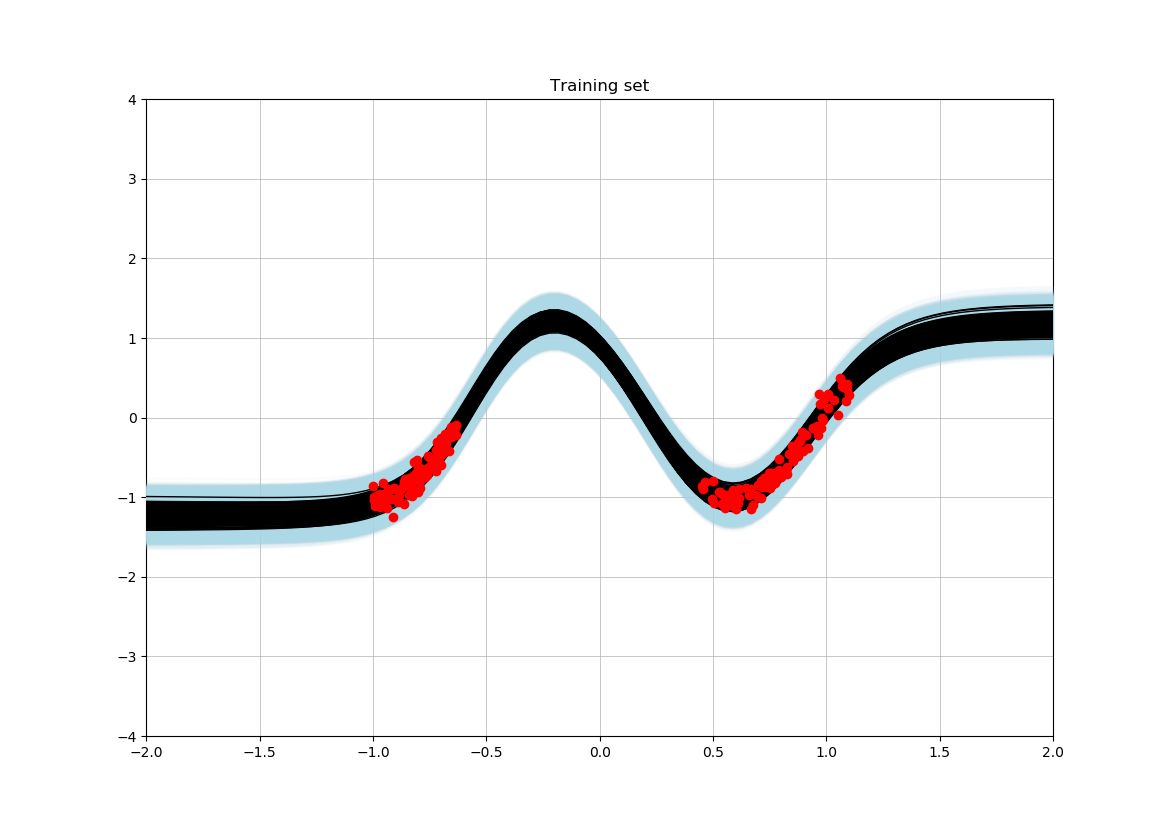

In [43]:
%matplotlib notebook
x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2)
plt.ylim(-4, 4)
plt.grid(True, which='major', linewidth=0.5)
plt.title('Training set')
for theta in ensemble:
    y_pred = exp.mlp(x_lin, theta)
    plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=1.0,
             linewidth=1.0, color='black', zorder=80)
    res = 5
    for r in range(res):
        mass = 1.0 - (r + 1) / res
        plt.fill_between(x_lin.detach().cpu().numpy().squeeze(),
                         y_pred.squeeze(0).detach().cpu().numpy().squeeze() - 3 * 0.1 * ((r + 1) / res),
                         y_pred.squeeze(0).detach().cpu().numpy().squeeze() + 3 * 0.1 * ((r + 1) / res),
                         alpha=0.2 * mass, color='lightblue', zorder=50)
plt.scatter(x_train.cpu(), y_train.cpu(), c='red', zorder=100)
plt.show()

In [17]:
q = MeanFieldVariationalDistribution(exp.param_count, sigma=0.0000001, device=device)
q.mu = nn.Parameter(theta.detach().clone(), requires_grad=True)
q.rho.requires_grad = True
q.mu.requires_grad = True

In [36]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay)

In [106]:
training_loss = []
for t in range(max_iter - 1):
    optimizer.zero_grad()

    z = q.sample(n_ELBO_samples)
    LQ = q.log_prob(z)
    LP = logposterior(z, x_train, y_train, sigma_noise=0.1)
    L = (LQ - LP).mean()

    L.backward()

    training_loss.append(L.detach().clone().cpu().numpy())

    lr = optimizer.param_groups[0]['lr']
    scheduler.step(L.detach().clone().cpu().numpy())
    if lr < min_lr:
        break
        
    stats = 'Epoch [{}/{}], Training Loss: {}, Learning Rate: {}'.format(t, max_iter, L, lr)
    print(stats)

    optimizer.step()

Epoch [0/100000], Training Loss: 103.0980453491211, Learning Rate: 0.011438396227480507
Epoch [1/100000], Training Loss: 103.58128356933594, Learning Rate: 0.011438396227480507
Epoch [2/100000], Training Loss: 102.58480072021484, Learning Rate: 0.011438396227480507
Epoch [3/100000], Training Loss: 103.0468521118164, Learning Rate: 0.011438396227480507
Epoch [4/100000], Training Loss: 102.82642364501953, Learning Rate: 0.011438396227480507
Epoch [5/100000], Training Loss: 104.3068618774414, Learning Rate: 0.011438396227480507
Epoch [6/100000], Training Loss: 102.29850006103516, Learning Rate: 0.011438396227480507
Epoch [7/100000], Training Loss: 102.53214263916016, Learning Rate: 0.011438396227480507
Epoch [8/100000], Training Loss: 102.59877014160156, Learning Rate: 0.011438396227480507
Epoch [9/100000], Training Loss: 103.66726684570312, Learning Rate: 0.011438396227480507
Epoch [10/100000], Training Loss: 101.97938537597656, Learning Rate: 0.011438396227480507
Epoch [11/100000], Trai

Epoch [94/100000], Training Loss: 101.37226104736328, Learning Rate: 0.011438396227480507
Epoch [95/100000], Training Loss: 102.10100555419922, Learning Rate: 0.011438396227480507
Epoch [96/100000], Training Loss: 102.38953399658203, Learning Rate: 0.011438396227480507
Epoch [97/100000], Training Loss: 101.04146575927734, Learning Rate: 0.011438396227480507
Epoch [98/100000], Training Loss: 102.04541015625, Learning Rate: 0.011438396227480507
Epoch [99/100000], Training Loss: 102.79669952392578, Learning Rate: 0.011438396227480507
Epoch [100/100000], Training Loss: 100.95171356201172, Learning Rate: 0.011438396227480507
Epoch [101/100000], Training Loss: 101.93506622314453, Learning Rate: 0.010294556604732457
Epoch [102/100000], Training Loss: 102.269287109375, Learning Rate: 0.010294556604732457
Epoch [103/100000], Training Loss: 103.19967651367188, Learning Rate: 0.010294556604732457
Epoch [104/100000], Training Loss: 102.99616241455078, Learning Rate: 0.010294556604732457
Epoch [105

KeyboardInterrupt: 